## **ML1: Supervised ML Final Project**

- **By : Mahmoud Ahmed Shawqi**
- **Intake : 44**
- **Track : AI**
- **Branch : Smart Village**

## 1- Installing mediapipe Lib

In [ ]:
!pip install mediapipe

## 2- Importing Libraries

In [1]:
import numpy as np
from pathlib import Path
import os,cv2
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import mediapipe as mp
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

## 3- Data cleaning (Check if any image does not have **face landmarks**)

In [2]:
def check_face_marks(folder_path):
    un_found_landmarks_images = []
    # Iterate over all files in the folder
    for file_path in folder_path.iterdir():
        if file_path.is_file():
            # Process the file here
            # print(file_path)
            faceModule = mp.solutions.face_mesh
            # loading image and its corresponding mat file
            with faceModule.FaceMesh(static_image_mode=True) as faces:
                # loading the image
                image = cv2.imread(str(file_path))  # Convert Path object to string
                # print(image.shape)  # Check the shape of the loaded image
                # processing the face to extract the landmark points (468 point) for each x,y,z
                results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                if results.multi_face_landmarks != None: 
                    # looping over the faces in the image
                    for face in results.multi_face_landmarks:
                        for landmark in face.landmark:
                            x = landmark.x
                            y = landmark.y
                            # note: the x and y values are scaled to their width and height so we will get back their actual value in the image
                            shape = image.shape 
                            relative_x = int(x * shape[1])
                            relative_y = int(y * shape[0])
                            # print(x,y)
                            # cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
                            cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
                else:
                    print(file_path, 'Un found face landmarks')
                    un_found_landmarks_images.append(file_path)
        else:
            print(file_path, 'UN_FOUND_file')
    return un_found_landmarks_images


folder_path = Path(r'.\Data')
un_found_landmarks_images = check_face_marks(folder_path)
unused_labels = []
for path in un_found_landmarks_images:
    unused_labels.append(Path(str(path).replace('Data', 'Labels').replace('jpg', 'mat')))

In [40]:
len(unused_labels)

147

## 4- Get all face landmarks **(Data)**

In [41]:
def get_all_faces_marks(folder_path, unmarked_images_paths):
    x_pos = []
    y_pos = []
    all_poses = []
    # Iterate over all files in the folder
    for file_path in filter(lambda x: x not in unmarked_images_paths, folder_path.iterdir()):
        if file_path.is_file():
            # Process the file here
            # print(file_path)
            faceModule = mp.solutions.face_mesh
            # loading image and its corresponding mat file
            with faceModule.FaceMesh(static_image_mode=True) as faces:
                # loading the image
                image = cv2.imread(str(file_path))  # Convert Path object to string
                # print(image.shape)  # Check the shape of the loaded image
                # processing the face to extract the landmark points (468 point) for each x,y,z
                results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                if results.multi_face_landmarks != None: 
                    # looping over the faces in the image
                    for face in results.multi_face_landmarks:
                        for landmark in face.landmark:
                            x = landmark.x
                            y = landmark.y
                            # note: the x and y values are scaled to their width and height so we will get back their actual value in the image
                            shape = image.shape 
                            relative_x = int(x * shape[1])
                            relative_y = int(y * shape[0])
                            x_pos.append(x)
                            y_pos.append(y)
                            # print(x,y)
                            # cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
                            cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
                        x_y_poses = np.array([x_pos, y_pos]).reshape((1,-1))
                        all_poses.append(x_y_poses)
                        x_pos.clear()
                        y_pos.clear()
    all_poses = np.array(all_poses)
    return all_poses            
                        


folder_path = Path(r'.\Data')
all_poses = get_all_faces_marks(folder_path, unused_labels)

## 5- Shaping and Dimensions adjusting

In [42]:
print(all_poses.shape)

(1853, 1, 936)


In [43]:
all_poses = all_poses.reshape((all_poses.shape[0], -1))
print(all_poses.shape)

(1853, 936)


In [44]:
data = pd.DataFrame(all_poses)
data.to_csv('data.csv', index=False)  


## 6- Gettint Angles (pitch, yaw, roll) ===>> **(Labels)**

In [96]:
def get_angles(folder_path, unused_labels):
    angles = []
    # Iterate over all files in the folder
    for file_path in folder_path.iterdir():
        if file_path in unused_labels:
            continue
        else:
            if file_path.is_file():
                # Process the file here
                mat_file = sio.loadmat(file_path)
                # extracting the labels 3 angels
                pose_para = mat_file["Pose_Para"][0][:3]
                pitch = pose_para[0]
                yaw = pose_para[1]
                roll = pose_para[2]
                angles.append([pitch, yaw, roll])
                # print(pitch, yaw, roll)
    angles = np.array(angles)
    return angles


folder_path = Path(r'.\Labels')
angles = get_angles(folder_path, unused_labels)
print(angles.shape)

(1853, 3)


In [97]:
df = pd.DataFrame(angles)
df.rename(columns={0: 'pitch', 1: 'yaw', 2: 'roll'}, inplace=True)
df.to_csv('labels.csv', index=False)
df.head()


,pitch,yaw,roll
0,-0.399231,0.018227,0.085676
1,0.470065,1.189533,0.300959
2,-0.184650,0.881137,-0.236852
3,-0.175379,0.299208,-0.373374
4,-0.026812,0.011965,-0.220662


## 7.1- Defining ML model Training :
- Features
- Labels

In [2]:
# all_poses = pd.read_csv('data.csv').to_numpy()
# angles = pd.read_csv('labels.csv').to_numpy()

In [16]:
features = all_poses[:]
labels = angles[:]
print(features.shape)
print(labels.shape)

(1853, 936)
(1853, 3)


## 7.2- Normalizing cordinates to reduce camera (frame) movement effect:

In [17]:
x = features[:, :468]
y = features[:, 468:]

# Normalize x
x_normalized = ((x - np.min(x, axis=1, keepdims=True)) / (np.max(x, axis=1, keepdims=True) - np.min(x, axis=1, keepdims=True)))

# Normalize y
y_normalized = ((y - np.min(y, axis=1, keepdims=True))  / (np.max(y, axis=1, keepdims=True) - np.min(y, axis=1, keepdims=True)))

print("Normalized x shape:", x_normalized.shape)
print("Normalized y shape:", y_normalized.shape)

features = np.hstack((x_normalized, y_normalized))

print("Reconstructed features shape:", features.shape)


Normalized x shape: (1853, 468)
Normalized y shape: (1853, 468)
Reconstructed features shape: (1853, 936)


## 8.1- Training 5 Different models (Linear Model Lasso - Elastic Net - Random Forest Regressor - Random forest - Decision Tree) and investigate metrics

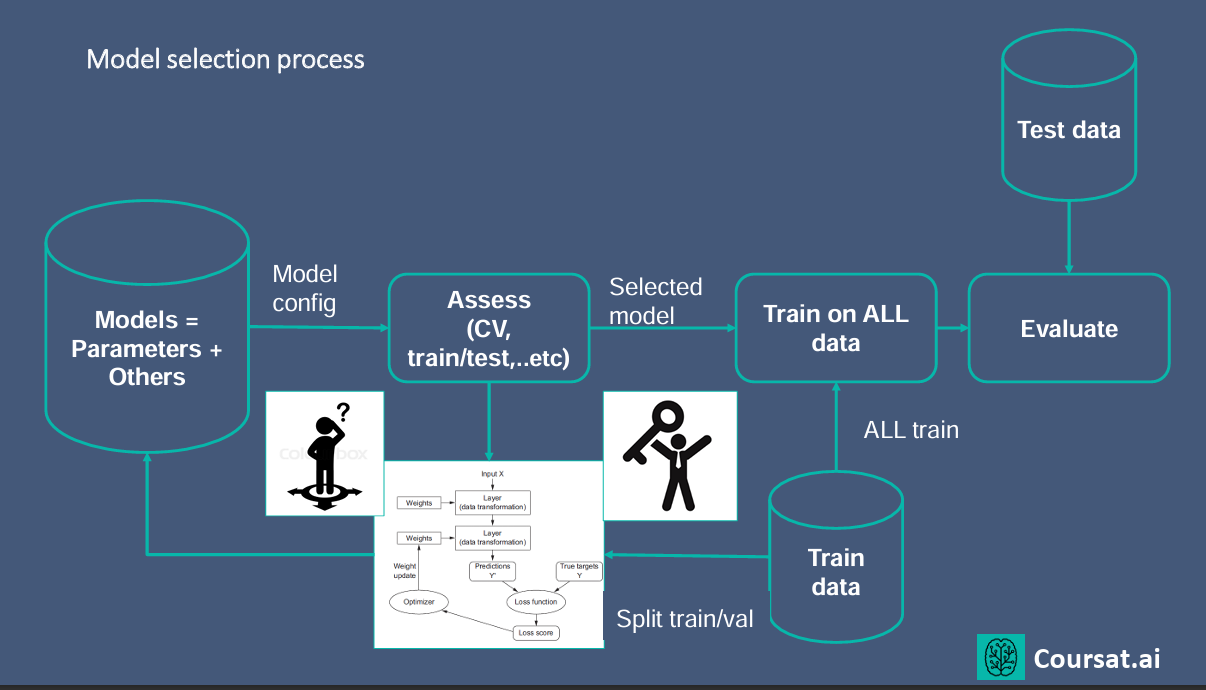

## 1- Score :

In [7]:
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

r_seed = 99
features_train, features_validation_test, labels_train, labels_validation_test = train_test_split(features, labels, test_size=0.4, random_state=r_seed)
features_validation, features_test, labels_validation, labels_test = train_test_split(features_validation_test, labels_validation_test, test_size=0.5, random_state=r_seed)

print('labels_train.shape = ', labels_train.shape)
print('labels_validation.shape = ', labels_validation.shape)
print('=' * 50)

## LinearRegression Lasso ##
lasso_reg = linear_model.Lasso(alpha=0.0001, max_iter=10000)
lasso_reg.fit(features_train, labels_train)

# ## LinearRegression Ridge ##
ridge_reg = Ridge(alpha=0.001, max_iter=10000)  
ridge_reg.fit(features_train, labels_train)

# ## ElasticNet Model ##
alpha = 0.001  # regularization strength
l1_ratio = 0.05  # mixing parameter for L1 and L2 penalties
elastic_net = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=r_seed)
elastic_net.fit(features_train, labels_train)

# ## Random Forest ##
random_forest_reg = RandomForestRegressor(n_estimators=100, max_depth=20, n_jobs=-1, random_state=r_seed)
random_forest_reg.fit(features_train, labels_train)

# ## Decision Tree ##
dt_regressor = DecisionTreeRegressor(max_depth=20, min_samples_split=10, min_samples_leaf=10, random_state=r_seed)
dt_regressor.fit(features_train, labels_train)

print('LR model Lasso: ')
print('Train : ', lasso_reg.score(features_train, labels_train))
print('Validation : ', lasso_reg.score(features_validation, labels_validation))
print('=' * 50)
print('LR model Ridge: ')
print('Train : ', ridge_reg.score(features_train, labels_train))
print('Validation : ', ridge_reg.score(features_validation, labels_validation))
print('=' * 50)
print('Elastic Net model : ')
print('Train : ', elastic_net.score(features_train, labels_train))
print('Validation : ', elastic_net.score(features_validation, labels_validation))
print('=' * 50)
print('Random Forest model : ')
print('Train : ', random_forest_reg.score(features_train, labels_train))
print('Validation : ', random_forest_reg.score(features_validation, labels_validation))
print('=' * 50)
print('Decision Tree model : ')
print('Train : ', dt_regressor.score(features_train, labels_train))
print('Validation : ', dt_regressor.score(features_validation, labels_validation))

labels_train.shape =  (1111, 3)
labels_validation.shape =  (371, 3)
LR model Lasso: 
Train :  0.5461943893400721
Validation :  0.5578790747210588
LR model Ridge: 
Train :  0.7635598337325518
Validation :  0.4336340238703153
Elastic Net model : 
Train :  0.516473864291377
Validation :  0.5786505841000171
Random Forest model : 
Train :  0.8976927800742852
Validation :  0.5830983950477692
Decision Tree model : 
Train :  0.5144570389459902
Validation :  0.5134384346496267


## 2- mse:

In [11]:
from sklearn.metrics import mean_squared_error
models = [lasso_reg, ridge_reg, elastic_net, random_forest_reg, dt_regressor]
for model in models:
    model.fit(features_train, labels_train)
    y_pred = model.predict(features_validation)
    mse = mean_squared_error(labels_validation, y_pred)
    print(f'MSE of  {model} is = {mse}')

MSE of  Lasso(alpha=0.0001, max_iter=10000) is = 0.06272185089016603
MSE of  Ridge(alpha=0.001, max_iter=10000) is = 0.08026532538476752
MSE of  ElasticNet(alpha=0.001, l1_ratio=0.05, random_state=99) is = 0.060165911584337615
MSE of  RandomForestRegressor(max_depth=20, n_jobs=-1, random_state=99) is = 0.05989561204310397
MSE of  DecisionTreeRegressor(max_depth=20, min_samples_leaf=10, min_samples_split=10,
                      random_state=99) is = 0.0713882212435128


## Checking **Kfold :**

In [18]:
from sklearn.model_selection import KFold

# Define the number of folds
n_splits = 5  # You can adjust the number of folds as needed

# Create KFold instance
kf = KFold(n_splits=n_splits, shuffle=True, random_state=r_seed)

# Initialize lists to store scores
# (you may need to adjust these based on your specific metrics)
lasso_train_scores = []
lasso_val_scores = []
ridge_train_scores = []
ridge_val_scores = []
elastic_net_train_scores = []
elastic_net_val_scores = []
random_forest_train_scores = []
random_forest_val_scores = []
dt_train_scores = []
dt_val_scores = []
features = pd.DataFrame(features)


# Loop over the folds
for train_index, val_index in kf.split(features):
    features_train, features_validation = features.iloc[train_index], features.iloc[val_index]
    labels_train, labels_validation = labels[train_index], labels[val_index]
    

# Loop over the folds
for train_index, val_index in kf.split(features, labels):
    features_train, features_validation = features.iloc[train_index], features.iloc[val_index]
    labels_train, labels_validation = labels[train_index], labels[val_index]
    

    ## LinearRegression Lasso ##
    lasso_reg_kfold = linear_model.Lasso(alpha=0.0001, max_iter=10000)
    lasso_reg_kfold.fit(features_train, labels_train)
    lasso_train_scores.append(lasso_reg_kfold.score(features_train, labels_train))
    lasso_val_scores.append(lasso_reg_kfold.score(features_validation, labels_validation))

    ## LinearRegression Ridge ##
    ridge_reg_kfold = Ridge(alpha=0.001, max_iter=10000)  
    ridge_reg_kfold.fit(features_train, labels_train)
    ridge_train_scores.append(ridge_reg_kfold.score(features_train, labels_train))
    ridge_val_scores.append(ridge_reg_kfold.score(features_validation, labels_validation))

    ## ElasticNet Model ##
    alpha = 0.001  # regularization strength
    l1_ratio = 0.05  # mixing parameter for L1 and L2 penalties
    elastic_net_kfold = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=r_seed)
    elastic_net_kfold.fit(features_train, labels_train)
    elastic_net_train_scores.append(elastic_net_kfold.score(features_train, labels_train))
    elastic_net_val_scores.append(elastic_net_kfold.score(features_validation, labels_validation))

    

    ## Decision Tree ##
    dt_regressor_kfold = DecisionTreeRegressor(max_depth=20, min_samples_split=10, min_samples_leaf=10, random_state=r_seed)
    dt_regressor_kfold.fit(features_train, labels_train)
    dt_train_scores.append(dt_regressor_kfold.score(features_train, labels_train))
    dt_val_scores.append(dt_regressor_kfold.score(features_validation, labels_validation))

# Print average scores
print('Average Train Scores:')
print('Lasso:', np.mean(lasso_train_scores))
print('Ridge:', np.mean(ridge_train_scores))
print('Elastic Net:', np.mean(elastic_net_train_scores))
print('Decision Tree:', np.mean(dt_train_scores))
print('=' * 50)
print('Average Validation Scores:')
print('Lasso:', np.mean(lasso_val_scores))
print('Ridge:', np.mean(ridge_val_scores))
print('Elastic Net:', np.mean(elastic_net_val_scores))
print('Decision Tree:', np.mean(dt_val_scores))


Average Train Scores:
Lasso: 0.498467735475287
Ridge: 0.6779710968569117
Elastic Net: 0.4791502455230642
Decision Tree: 0.5142261065276631
Average Validation Scores:
Lasso: 0.5069410207349481
Ridge: 0.26514097506392253
Elastic Net: 0.5347140360548506
Decision Tree: 0.41900316215397426


### **From previous results, it seems that ELASTIC NET regressor is the best !!**
#### **Let's Test ..**
## **But first !! Train the models on ALL DATA SET**


## 8.2- TRAINING Models on all dataset :

In [19]:
## LinearRegression Lasso ##
lasso_reg = linear_model.Lasso(alpha=0.0001, max_iter=10000)
lasso_reg.fit(features, labels)

# ## LinearRegression Ridge ##
ridge_reg = Ridge(alpha=0.001, max_iter=10000)  
ridge_reg.fit(features, labels)

# ## ElasticNet Model ##
alpha = 0.001  # regularization strength
l1_ratio = 0.05  # mixing parameter for L1 and L2 penalties
elastic_net = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=r_seed)
elastic_net.fit(features, labels)

# ## Random Forest ##
random_forest_reg = RandomForestRegressor(n_estimators=100, max_depth=20, n_jobs=-1, random_state=r_seed)
random_forest_reg.fit(features, labels)

# ## Decision Tree ##
dt_regressor = DecisionTreeRegressor(max_depth=20, min_samples_split=10, min_samples_leaf=10, random_state=r_seed)
dt_regressor.fit(features, labels)

DecisionTreeRegressor(max_depth=20, min_samples_leaf=10, min_samples_split=10,
                      random_state=99)

## 8.3- Testing Models:

In [20]:
models = [lasso_reg, ridge_reg, elastic_net, random_forest_reg, dt_regressor]
for model in models:
    print(f':{model} Model ')
    print('Test : ', model.score(features_test, labels_test))
    print('=' * 50)


:Lasso(alpha=0.0001, max_iter=10000) Model 
Test :  0.4255966668624341
:Ridge(alpha=0.001, max_iter=10000) Model 
Test :  0.6348877311597556
:ElasticNet(alpha=0.001, l1_ratio=0.05, random_state=99) Model 
Test :  0.4105806053382916
:RandomForestRegressor(max_depth=20, n_jobs=-1, random_state=99) Model 
Test :  0.9211284535946335
:DecisionTreeRegressor(max_depth=20, min_samples_leaf=10, min_samples_split=10,
                      random_state=99) Model 
Test :  0.47330152438864026


### **WE Are now see LR Lasso, and Elastic Net are the best models**

## 9- Saving the 5 Models locally

In [21]:
import joblib
joblib.dump(lasso_reg, 'lasso_reg_model.pkl')
joblib.dump(ridge_reg, 'ridge_reg.pkl')
joblib.dump(elastic_net, 'elastic_net.pkl')
joblib.dump(random_forest_reg, 'random_forest_reg.pkl')
joblib.dump(dt_regressor, 'dt_regressor.pkl')

['dt_regressor.pkl']

## 10- Use one model (Lasso Model)

In [2]:
import joblib
loaded_model = joblib.load('elastic_net.pkl')

## 11- Testing the model on Real Data from life

(1, 936)
[[ 0.13911558 -0.00188543 -0.02763582]]


True

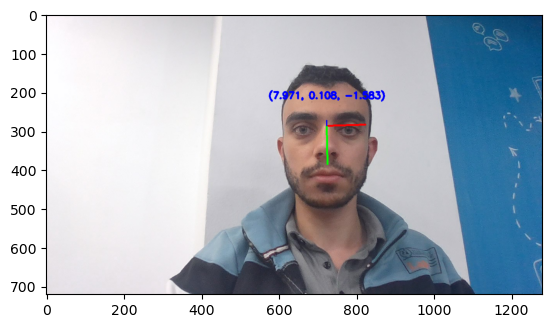

In [40]:
def get_face_points(image_path):
    x_pos = []
    y_pos = []
    faceModule = mp.solutions.face_mesh
    # loading image and its corresponding mat file
    with faceModule.FaceMesh(static_image_mode=True) as faces:
        # loading the image
        image = cv2.imread(image_path)
        # processing the face to extract the landmark points (468 points) for each x,y,z
        results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if results.multi_face_landmarks != None: 
            # looping over the faces in the image
            for face in results.multi_face_landmarks:
                for landmark in face.landmark:
                    x = landmark.x
                    y = landmark.y
                    # note: the x and y values are scaled to their width and height so we will get back their actual value in the image
                    shape = image.shape 
                    relative_x = int(x * shape[1])
                    relative_y = int(y * shape[0])
                    x_pos.append(x)
                    y_pos.append(y)
                    x_pos_arr = np.array(x_pos)
                    y_pos_arr = np.array(y_pos)
                    cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
                    cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
    x_normalized = ((x_pos - np.min(x_pos_arr)) / (np.max(x_pos_arr) - np.min(x_pos_arr)))
    y_normalized = ((y_pos - np.min(y_pos_arr)) / (np.max(y_pos_arr) - np.min(y_pos_arr)))
    poses = np.hstack((x_normalized, y_normalized)).reshape((1, -1))
    tdx = shape[1] * x_pos[168]
    tdy = shape[0] * y_pos[168]
    return poses, tdx, tdy


def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):
    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 8
        tdy = height / 8

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.putText(img, str((round(pitch * 180 / np.pi, 3), round(yaw * 180 / np.pi, 3), round(roll * 180 / np.pi, 3))), (int(tdx-150),int(tdy-70)), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,0,0), 4)
    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img


my_path = str(Path(r".\my_img_1.jpg"))
pose, tdx, tdy = get_face_points(my_path)
print(pose.shape)

angle = loaded_model.predict(pose)
print(angle)

image = cv2.imread(my_path)
pitch = angle[0,0]
yow = angle[0,1]
roll = angle[0,2]
output_image = draw_axis(image,pitch,yow,roll, tdx=tdx, tdy=tdy)
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
cv2.imwrite('output_image.jpg', output_image)


## 12- Use WebCam :

In [4]:

def draw_lines(image, pitch, yaw, roll, tdx=None, tdy=None, size=100):
    yaw = -yaw
    if tdx is None and tdy is None:
        height, width = image.shape[:2]
        tdx = width / 8
        tdy = height / 8

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    # Convert float coordinates to integers
    pt1 = (int(tdx), int(tdy))
    pt2_x1_y1 = (int(x1), int(y1))
    pt2_x2_y2 = (int(x2), int(y2))
    pt2_x3_y3 = (int(x3), int(y3))
    # Draw lines
    cv2.putText(image, str((round(pitch * 180 / np.pi, 3), round(yaw * 180 / np.pi, 3), round(roll * 180 / np.pi, 3))), (int(10),int(30)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 5)
    cv2.line(image, pt1, pt2_x1_y1, (0, 0, 255), 3)  # X-Axis (Red)
    cv2.line(image, pt1, pt2_x2_y2, (0, 255, 0), 3)  # Y-Axis (Green)
    cv2.line(image, pt1, pt2_x3_y3, (255, 0, 0), 2)  # Z-Axis (Blue)

In [30]:
mp_face_detection = mp.solutions.face_detection
mp_face_mesh = mp.solutions.face_mesh

face_detection = mp_face_detection.FaceDetection()
face_mesh = mp_face_mesh.FaceMesh()

cap = cv2.VideoCapture(0)

while cap.isOpened():

# Fit the scaler to your data and transform it
    
    ret, frame = cap.read()
    if not ret:
        break

    # Resize the frame to 450x450
    # frame = cv2.resize(frame, (450, 450))

    # Convert the image to RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # Face detection
    result_detection = face_detection.process(frame_rgb)

    if result_detection.detections:
        for detection in result_detection.detections:
            bboxC = detection.location_data.relative_bounding_box
            ih, iw, _ = frame.shape
            bbox = int(bboxC.xmin * iw), int(bboxC.ymin * ih), \
                   int(bboxC.width * iw), int(bboxC.height * ih)
            cv2.rectangle(frame, bbox, (255, 0, 255), 2)

    # Face landmark detection
    result_landmarks = face_mesh.process(frame_rgb)

    if result_landmarks.multi_face_landmarks:
        for face_landmarks in result_landmarks.multi_face_landmarks:
            landmarks = []
            for lm in face_landmarks.landmark:
                # x_0, y_0 = int(lm.x * iw), int(lm.y * ih)
                x, y = (lm.x), (lm.y)
                landmarks.append([x, y])
                # cv2.circle(frame, (x, y), 2, (0, 255, 255), -1)
            
            # Convert landmarks to NumPy array
            landmarks_np = np.array(landmarks)

            # Output the NumPy matrix
            # print("Facial Landmarks Matrix:")
            # print(landmarks_np)
            x = landmarks_np[:, 0].reshape((1,-1))
            y = landmarks_np[:, 1].reshape((1,-1))
            x_y = np.hstack((x, y))        
            x = x_y[:, :468]
            y = x_y[:, 468:]
            # Normalize x
            x_normalized = ((x - np.min(x, axis=1, keepdims=True)) / (np.max(x, axis=1, keepdims=True) - np.min(x, axis=1, keepdims=True)))
            # Normalize y
            y_normalized = ((y - np.min(y, axis=1, keepdims=True))  / (np.max(y, axis=1, keepdims=True) - np.min(y, axis=1, keepdims=True)))
            x_y = np.hstack((x_normalized, y_normalized))
            angle = loaded_model.predict(x_y)
            pitch = angle[0,0]
            yaw = angle[0,1]
            roll = angle[0,2]
            draw_lines(frame, pitch, yaw, roll, tdx=x[0,168]*iw, tdy=y[0,168]*ih, size=100)

    # Display the frame
    cv2.imshow('Face Detection and Landmarks', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

face_detection.close()
face_mesh.close()
cap.release()
cv2.destroyAllWindows()


## 13- Making Video :

In [ ]:
pip install moviepy


In [ ]:
pip install pydub

In [1]:
pip install ffpyplayer

In [24]:
# from ffpyplayer.player import MediaPlayer
# video_path = "D:\ITI_Schoolarship\ML_Supervised\Project\my_vid_0.mp4"  # Replace with the path to your video file
# def PlayVideo(video_path):
#     video=cv2.VideoCapture(video_path)
#     player = MediaPlayer(video_path)
#     while True:
#         grabbed, frame=video.read()
#         audio_frame, val = player.get_frame()
#         if not grabbed:
#             print("End of video")
#             break
#         if cv2.waitKey(28) & 0xFF == ord("q"):
#             break
#         cv2.imshow("Video", frame)
#         if val != 'eof' and audio_frame is not None:
#             #audio
#             img, t = audio_frame
#     video.release()
#     cv2.destroyAllWindows()
# PlayVideo(video_path)

In [6]:
from moviepy.editor import VideoFileClip

# Open the video file
video_path = "my_vid_1.mp4" 
cap = cv2.VideoCapture(video_path)

mp_face_detection = mp.solutions.face_detection
mp_face_mesh = mp.solutions.face_mesh

face_detection = mp_face_detection.FaceDetection()
face_mesh = mp_face_mesh.FaceMesh()

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'X264')
output_video_path = "output_video_test_1.mp4"
output_video = cv2.VideoWriter(output_video_path, fourcc, 30.0, (int(cap.get(3)), int(cap.get(4))))

# Extract original audio
video_clip = VideoFileClip(video_path)
original_audio = video_clip.audio

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert the image to RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # Face detection
    result_detection = face_detection.process(frame_rgb)

    if result_detection.detections:
        for detection in result_detection.detections:
            bboxC = detection.location_data.relative_bounding_box
            ih, iw, _ = frame.shape
            bbox = int(bboxC.xmin * iw), int(bboxC.ymin * ih), \
                   int(bboxC.width * iw), int(bboxC.height * ih)
            cv2.rectangle(frame, bbox, (255, 0, 255), 2)

    # Face landmark detection
    result_landmarks = face_mesh.process(frame_rgb)

    if result_landmarks.multi_face_landmarks:
        for face_landmarks in result_landmarks.multi_face_landmarks:
            landmarks = []
            for lm in face_landmarks.landmark:
                x, y = (lm.x), (lm.y)
                landmarks.append([x, y])
            
            # Convert landmarks to NumPy array
            landmarks_np = np.array(landmarks)

            # Output the NumPy matrix
            x = landmarks_np[:, 0].reshape((1,-1))
            y = landmarks_np[:, 1].reshape((1,-1))
            x_y = np.hstack((x, y))        
            x = x_y[:, :468]
            y = x_y[:, 468:]
            x_normalized = ((x - np.min(x, axis=1, keepdims=True)) / (np.max(x, axis=1, keepdims=True) - np.min(x, axis=1, keepdims=True)))
            # Normalize y
            y_normalized = ((y - np.min(y, axis=1, keepdims=True))  / (np.max(y, axis=1, keepdims=True) - np.min(y, axis=1, keepdims=True)))
            x_y = np.hstack((x_normalized, y_normalized))
            angles = loaded_model.predict(x_y)
            pitch = angles[0,0]
            yaw = angles[0,1]
            roll = angles[0,2]
            draw_lines(frame, pitch, yaw, roll, tdx=x[0,168]*iw, tdy=y[0,168]*ih, size=100)

    # Write the frame into the output video
    output_video.write(frame)

    # Display the frame
    cv2.imshow('Face Detection and Landmarks', frame)

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

# Release everything if job is finished
face_detection.close()
face_mesh.close()
cap.release()
output_video.release()
cv2.destroyAllWindows()

# Merge the processed video with the original audio
final_video = VideoFileClip(output_video_path)
final_video = final_video.set_audio(original_audio)
final_video.write_videofile("final_output_1.mp4", codec='libx264')


Moviepy - Building video final_output_1.mp4.
MoviePy - Writing audio in final_output_1TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video final_output_1.mp4



Moviepy - Done !
Moviepy - video ready final_output_1.mp4


## ***(ADDITIONAL) 14- Trying to make PCA and retrain the models*** 🤷‍♂️🤷‍♂️😎

## **Selecting 7 PCs**

In [28]:
from sklearn.decomposition import PCA
pca = PCA(n_components=7)
pca_data = pca.fit(features)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.74768448 0.14383053 0.05120142 0.03219784 0.01189395 0.0039767
 0.00319791]
[149.08755228  65.38945851  39.01424497  30.93823734  18.80378744
  10.87285792   9.75024292]


In [29]:
np.cumsum(pca.explained_variance_ratio_)

array([0.74768448, 0.891515  , 0.94271642, 0.97491426, 0.98680822,
       0.99078492, 0.99398283])

## **Preparing the new Data for Training**

In [30]:
new_data = pca.transform(features)
new_data = pd.DataFrame(new_data)
new_data

,0,1,2,3,4,5,6
0,-0.896201,-0.707157,-0.724163,-0.558274,0.075540,0.059856,0.349266
1,-6.025000,-0.300488,1.205319,0.114359,-0.828677,-0.173703,-0.160674
2,1.492157,-0.050130,-0.668118,0.453361,0.068124,0.021304,0.385217
3,-1.335605,2.128302,-0.030485,-0.894660,0.048836,0.126572,0.221498
4,0.023624,1.319234,-0.239737,0.268630,0.080335,0.042764,-0.136029
...,...,...,...,...,...,...,...
1848,2.804218,-0.356219,-0.648372,-0.484298,0.042756,-0.171136,-0.062791
1849,2.587604,-0.699839,-0.594775,-0.380257,-0.073537,-0.168693,0.211367
1850,0.175820,-1.963696,-0.193262,0.232811,0.192775,-0.099134,0.130300
1851,-0.186203,-0.831275,-0.753098,-0.824207,0.189537,-0.043492,-0.115623


## **Train the new models**

In [43]:
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor


new_features = new_data
r_seed = 99

features_train, features_validation_test, labels_train, labels_validation_test = train_test_split(new_features, labels, test_size=0.4, random_state=r_seed)
features_validation, features_test, labels_validation, labels_test = train_test_split(features_validation_test, labels_validation_test, test_size=0.5, random_state=r_seed)


print('labels_train.shape = ', labels_train.shape)
print('labels_validation.shape = ', labels_validation.shape)
print('=' * 50)

## LR ##
LR_PC7 = LinearRegression()
LR_PC7.fit(features_train, labels_train)

## LinearRegression Lasso ##
lasso_reg_PC7 = linear_model.Lasso(alpha=0.001)
lasso_reg_PC7.fit(features_train, labels_train)

## LinearRegression Ridge ##
ridge_reg_PC7 = Ridge(alpha=0.002)  
ridge_reg_PC7.fit(features_train, labels_train)

## ElasticNet Model ##
alpha = 0.0005  # regularization strength
l1_ratio = 0.1  # mixing parameter for L1 and L2 penalties
elastic_net_PC7 = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=r_seed)
elastic_net_PC7.fit(features_train, labels_train)

## Random Forest ##
random_forest_reg_PC7 = RandomForestRegressor(n_estimators=100, max_depth=20, n_jobs=-1, random_state=r_seed)
random_forest_reg_PC7.fit(features_train, labels_train)

## Decision Tree ##
dt_regressor_PC7 = DecisionTreeRegressor(max_depth=300, min_samples_split=20, min_samples_leaf=10, random_state=r_seed)
dt_regressor_PC7.fit(features_train, labels_train)

models_PC7 = [LR_PC7, lasso_reg_PC7, ridge_reg_PC7, elastic_net_PC7, random_forest_reg_PC7, dt_regressor_PC7]

for model in models_PC7:
    print(f'{model} : ')
    print('Train : ', model.score(features_train, labels_train))
    print('Validation : ', model.score(features_validation, labels_validation))
    print('=' * 50)

labels_train.shape =  (1111, 3)
labels_validation.shape =  (371, 3)
LinearRegression() : 
Train :  0.4775001473368778
Validation :  0.5711427139268964
Lasso(alpha=0.001) : 
Train :  0.4773698749130862
Validation :  0.5712034547202628
Ridge(alpha=0.002) : 
Train :  0.4775001473162714
Validation :  0.5711426722226841
ElasticNet(alpha=0.0005, l1_ratio=0.1, random_state=99) : 
Train :  0.47749755570354546
Validation :  0.57114432977131
RandomForestRegressor(max_depth=20, n_jobs=-1, random_state=99) : 
Train :  0.9038718621961083
Validation :  0.5958522399896017
DecisionTreeRegressor(max_depth=300, min_samples_leaf=10, min_samples_split=20,
                      random_state=99) : 
Train :  0.5093187471686103
Validation :  0.4738480692695975


In [55]:
for model in models_PC7:
    model.fit(new_features, labels)

In [56]:
for model in models_PC7:
    print(f'{model} : ')
    print('Test : ', model.score(features_test, labels_test))
    print('=' * 50)

LinearRegression() : 
Test :  0.3771148539106061
Lasso(alpha=0.001) : 
Test :  0.3771427874922469
Ridge(alpha=0.002) : 
Test :  0.3771146207718175
ElasticNet(alpha=0.0005, l1_ratio=0.1, random_state=99) : 
Test :  0.37702732228944297
RandomForestRegressor(max_depth=20, n_jobs=-1, random_state=99) : 
Test :  0.9135150079684934
DecisionTreeRegressor(max_depth=300, min_samples_leaf=10, min_samples_split=20,
                      random_state=99) : 
Test :  0.47023641868415705


## **Save The models :**

In [57]:
import joblib
joblib.dump(LR_PC7, 'LR_model_PC7.pkl')
joblib.dump(ridge_reg_PC7, 'ridge_reg_PC7.pkl')
joblib.dump(lasso_reg_PC7, 'lasso_reg_PC7.pkl')
joblib.dump(elastic_net_PC7, 'elastic_net_PC7.pkl')
joblib.dump(random_forest_reg_PC7, 'random_forest_reg_PC7.pkl')
joblib.dump(dt_regressor_PC7, 'dt_regressor_PC7.pkl')

['dt_regressor_PC7.pkl']

In [42]:
from sklearn.model_selection import KFold

# Define the number of folds
n_splits = 5  # You can adjust the number of folds as needed

# Create KFold instance
kf = KFold(n_splits=n_splits, shuffle=True, random_state=r_seed)

# Initialize lists to store scores
# (you may need to adjust these based on your specific metrics)
LR_train_scores = []
LR_val_scores = []
lasso_train_scores = []
lasso_val_scores = []
ridge_train_scores = []
ridge_val_scores = []
elastic_net_train_scores = []
elastic_net_val_scores = []
random_forest_train_scores = []
random_forest_val_scores = []
dt_train_scores = []
dt_val_scores = []

# Loop over the folds
for train_index, val_index in kf.split(new_features):
    features_train, features_validation = new_features.iloc[train_index], new_features.iloc[val_index]
    labels_train, labels_validation = labels[train_index], labels[val_index]
    

# Loop over the folds
for train_index, val_index in kf.split(new_features, labels):
    features_train, features_validation = new_features.iloc[train_index], new_features.iloc[val_index]
    labels_train, labels_validation = labels[train_index], labels[val_index]
    
    ## LR ##
    LR_PC7 = LinearRegression()
    LR_PC7.fit(features_train, labels_train)
    LR_train_scores.append(LR_PC7.score(features_train, labels_train))
    LR_val_scores.append(LR_PC7.score(features_validation, labels_validation))

    ## LinearRegression Lasso ##
    reg_PC7 = linear_model.Lasso(alpha=0.001)
    reg_PC7.fit(features_train, labels_train)
    lasso_train_scores.append(reg_PC7.score(features_train, labels_train))
    lasso_val_scores.append(reg_PC7.score(features_validation, labels_validation))

    ## LinearRegression Ridge ##
    ridge_reg_PC7 = Ridge(alpha=0.002)
    ridge_reg_PC7.fit(features_train, labels_train)
    ridge_train_scores.append(ridge_reg_PC7.score(features_train, labels_train))
    ridge_val_scores.append(ridge_reg_PC7.score(features_validation, labels_validation))

    ## ElasticNet Model ##
    alpha = 0.005  # regularization strength
    l1_ratio = 0.1  # mixing parameter for L1 and L2 penalties
    elastic_net_PC7 = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=r_seed)
    elastic_net_PC7.fit(features_train, labels_train)
    elastic_net_train_scores.append(elastic_net_PC7.score(features_train, labels_train))
    elastic_net_val_scores.append(elastic_net_PC7.score(features_validation, labels_validation))

    ## Random Forest ##
    random_forest_reg_PC7 = RandomForestRegressor(n_estimators=100, max_depth=20, n_jobs=-1, random_state=r_seed)
    random_forest_reg_PC7.fit(features_train, labels_train)
    random_forest_train_scores.append(random_forest_reg_PC7.score(features_train, labels_train))
    random_forest_val_scores.append(random_forest_reg_PC7.score(features_validation, labels_validation))

    ## Decision Tree ##
    dt_regressor_PC7 = DecisionTreeRegressor(max_depth=300, min_samples_split=5, min_samples_leaf=5, random_state=r_seed)
    dt_regressor_PC7.fit(features_train, labels_train)
    dt_train_scores.append(dt_regressor_PC7.score(features_train, labels_train))
    dt_val_scores.append(dt_regressor_PC7.score(features_validation, labels_validation))

# Print average scores
print('Average Train Scores:')
print('LR:', np.mean(LR_train_scores))
print('Lasso:', np.mean(lasso_train_scores))
print('Ridge:', np.mean(ridge_train_scores))
print('Elastic Net:', np.mean(elastic_net_train_scores))
print('Random Forest:', np.mean(random_forest_train_scores))
print('Decision Tree:', np.mean(dt_train_scores))
print('=' * 50)
print('Average Validation Scores:')
print('LR:', np.mean(LR_val_scores))
print('Lasso:', np.mean(lasso_val_scores))
print('Ridge:', np.mean(ridge_val_scores))
print('Elastic Net:', np.mean(elastic_net_val_scores))
print('Random Forest:', np.mean(random_forest_val_scores))
print('Decision Tree:', np.mean(dt_val_scores))


Average Train Scores:
LR: 0.6900143216986422
Lasso: 0.6894478643190406
Ridge: 0.6900143210974826
Elastic Net: 0.6876731453989371
Random Forest: 0.9437001060736161
Decision Tree: 0.766415908733869
Average Validation Scores:
LR: 0.6524705650718399
Lasso: 0.6547709730256154
Ridge: 0.6524720840668137
Elastic Net: 0.6538575086472507
Random Forest: 0.6019510063150373
Decision Tree: 0.4288786544382665


In [58]:
mp_face_detection = mp.solutions.face_detection
mp_face_mesh = mp.solutions.face_mesh

face_detection = mp_face_detection.FaceDetection()
face_mesh = mp_face_mesh.FaceMesh()

cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert the image to RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # Face detection
    result_detection = face_detection.process(frame_rgb)

    if result_detection.detections:
        for detection in result_detection.detections:
            bboxC = detection.location_data.relative_bounding_box
            ih, iw, _ = frame.shape
            bbox = int(bboxC.xmin * iw), int(bboxC.ymin * ih), \
                   int(bboxC.width * iw), int(bboxC.height * ih)
            cv2.rectangle(frame, bbox, (255, 0, 255), 2)

    # Face landmark detection
    result_landmarks = face_mesh.process(frame_rgb)

    if result_landmarks.multi_face_landmarks:
        for face_landmarks in result_landmarks.multi_face_landmarks:
            landmarks = []
            for lm in face_landmarks.landmark:
                # x_0, y_0 = int(lm.x * iw), int(lm.y * ih)
                x, y = (lm.x), (lm.y)
                landmarks.append([x, y])
                # cv2.circle(frame, (x, y), 2, (0, 255, 255), -1)
            
            # Convert landmarks to NumPy array
            landmarks_np = np.array(landmarks)

            # Output the NumPy matrix
            # print("Facial Landmarks Matrix:")
            # print(landmarks_np)
            x = landmarks_np[:, 0].reshape((1,-1))
            y = landmarks_np[:, 1].reshape((1,-1))
            x_y = np.hstack((x, y))        
            x = x_y[:, :468]
            y = x_y[:, 468:]
            # Normalize x
            x_normalized = ((x - np.min(x, axis=1, keepdims=True)) / (np.max(x, axis=1, keepdims=True) - np.min(x, axis=1, keepdims=True)))

            # Normalize y
            y_normalized = ((y - np.min(y, axis=1, keepdims=True))  / (np.max(y, axis=1, keepdims=True) - np.min(y, axis=1, keepdims=True)))
            x_y = np.hstack((x_normalized, y_normalized))
            new_x_y = pca.transform(x_y)
            angles_PC7 = LR_PC7.predict(new_x_y)
            pitch = angles_PC7[0,0]
            yaw = angles_PC7[0,1]
            roll = angles_PC7[0,2]
            draw_lines(frame, pitch, yaw, roll, tdx=x[0,168]*iw, tdy=y[0,168]*ih, size=100)

    # Display the frame
    cv2.imshow('Face Detection and Landmarks', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

face_detection.close()
face_mesh.close()
cap.release()
cv2.destroyAllWindows()


In [38]:
from moviepy.editor import VideoFileClip

# Open the video file
video_path = "test.mp4" 
cap = cv2.VideoCapture(video_path)

mp_face_detection = mp.solutions.face_detection
mp_face_mesh = mp.solutions.face_mesh

face_detection = mp_face_detection.FaceDetection()
face_mesh = mp_face_mesh.FaceMesh()

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'X264')
output_video_path = "output_video_test.mp4"
output_video = cv2.VideoWriter(output_video_path, fourcc, 30.0, (int(cap.get(3)), int(cap.get(4))))

# Extract original audio
video_clip = VideoFileClip(video_path)
original_audio = video_clip.audio

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert the image to RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # Face detection
    result_detection = face_detection.process(frame_rgb)

    if result_detection.detections:
        for detection in result_detection.detections:
            bboxC = detection.location_data.relative_bounding_box
            ih, iw, _ = frame.shape
            bbox = int(bboxC.xmin * iw), int(bboxC.ymin * ih), \
                   int(bboxC.width * iw), int(bboxC.height * ih)
            cv2.rectangle(frame, bbox, (255, 0, 255), 2)

    # Face landmark detection
    result_landmarks = face_mesh.process(frame_rgb)

    if result_landmarks.multi_face_landmarks:
        for face_landmarks in result_landmarks.multi_face_landmarks:
            landmarks = []
            for lm in face_landmarks.landmark:
                x, y = (lm.x), (lm.y)
                landmarks.append([x, y])
            
            # Convert landmarks to NumPy array
            landmarks_np = np.array(landmarks)

            # Output the NumPy matrix
            x = landmarks_np[:, 0].reshape((1,-1))
            y = landmarks_np[:, 1].reshape((1,-1))
            x_y = np.hstack((x, y))        
            x = x_y[:, :468]
            y = x_y[:, 468:]
            x_normalized = ((x - np.min(x, axis=1, keepdims=True)) / (np.max(x, axis=1, keepdims=True) - np.min(x, axis=1, keepdims=True)))
            # Normalize y
            y_normalized = ((y - np.min(y, axis=1, keepdims=True))  / (np.max(y, axis=1, keepdims=True) - np.min(y, axis=1, keepdims=True)))
            x_y = np.hstack((x_normalized, y_normalized))
            new_x_y = pca.transform(x_y)
            angles = LR_PC7.predict(new_x_y)
            pitch = angles[0,0]
            yaw = angles[0,1]
            roll = angles[0,2]
            draw_lines(frame, pitch, yaw, roll, tdx=x[0,168]*iw, tdy=y[0,168]*ih, size=100)

    # Write the frame into the output video
    output_video.write(frame)

    # Display the frame
    cv2.imshow('Face Detection and Landmarks', frame)

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

# Release everything if job is finished
face_detection.close()
face_mesh.close()
cap.release()
output_video.release()
cv2.destroyAllWindows()

# Merge the processed video with the original audio
final_video = VideoFileClip(output_video_path)
final_video = final_video.set_audio(original_audio)
final_video.write_videofile("final_output.mp4", codec='libx264')
